In [17]:
#installing flygym to use juypternotebook
import os
os.chdir('..')
import sys
path = '/Users/laeti/Documents/EPFL/BA6Projet/flygym_adhesion-Laetitia'# replace 'my_folder' with the name of your folder
os.chdir(path)
sys.path.append(path)

In [18]:
os.getcwd()

'c:\\Users\\laeti\\Documents\\EPFL\\BA6Projet\\flygym_adhesion-Laetitia'

In [19]:
pip install -e ."[mujoco]

Obtaining file:///C:/Users/laeti/Documents/EPFL/BA6Projet/flygym_adhesion-Laetitia
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: flygym
    Found existing installation: flygym 0.0.1
    Uninstalling flygym-0.0.1:
      Successfully uninstalled flygym-0.0.1
  Running setup.py develop for flygym
Note: you may need to restart the kernel to use updated packages.


# Contact forces analysis with normal gravity

In [110]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs

from scipy.signal import medfilt


## part 1: Static analysis split by leg

In [22]:
# Initialize simulation
run_time = 1
nmf = NeuroMechFlyMuJoCo(render_mode='headless', #no graphic rendering: headless, rendering = 'saved'
                         timestep=1e-4,
                         #render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs,
                         adhesion = False,
                         actuators_adhesion_gain = 4000,## before 1942.73 at 20500 it flies away, at 21000 it stays
                         actuated_bodies='all')

# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
#with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
#    data = pickle.load(f)
with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
    data = pickle.load(f)

# Interpolate 5x recording 
num_steps = int(run_time / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), num_steps))
measure_t = np.arange(len(data['joint_LFCoxa'])) * data['meta']['timestep']
interp_t = np.arange(num_steps) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4000"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4000"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4000"/>] actuators _adhesion


In [71]:
def interval_adhesion_state(off_duration, on_duration, off_increase, on_increase, num_steps):
    """
    off_duration, on_duration:  interval durations for which adhesion is on/ off,
    off_increase, on_increase:  by how many timesteps these intervals are increased size
    """
    adhesion_state = np.zeros(num_steps, dtype=bool)
    i = 0
    while i < num_steps:
        adhesion_state[i:i+off_duration] = False
        adhesion_state[i+off_duration:i+off_duration+on_duration] = True
        i += off_duration + on_duration
        off_duration += off_increase
        on_duration += on_increase
    return adhesion_state
off_duration = 10
on_duration = 10
off_increase = 20
on_increase = 20

adhesion_state = interval_adhesion_state(off_duration, on_duration, off_increase, on_increase, num_steps)


[False False False ... False False False]
(10000,)


### auxiliary functions

In [85]:
# The simulation will be run twice, once with the adhesion: np.zeros(6) and once with np.ones(6) and np.zeros(6) alternating during varying times. 
# The adhesion is applied to the tarsus 5 of each leg.
# We want to plot the forces applied to the tarsus 5 of each leg. on the same plot but with 6 subplots, one for each leg. The first run is on the primary axis, the second run on the secondary axis. 
# The forces are plotted in the order of the legs: LFTarsus5, LHTarsus5, RMTarsus5, RFTarsus5, RHTarsus5, LMTarsus5
# The final video will be recorded. 


def run_simulation_static(num_steps, adhesion_feature = None):
    #adhesion_feature: Array denoting whether adhesion is on or off at each timestep.

    adhesion_states = np.zeros((num_steps,6))
    if adhesion_feature is not None:
        adhesion_states[adhesion_feature] = np.ones(6)
    
    # Run simulation
    nmf.physics.model.opt.gravity = (0,0,-9.81e5)
    obs, info = nmf.reset() 
    obs_list = [obs]
    for i in trange(num_steps):
        joint_pos = data_block[:, 0] #0 for static, i for dynamic
        
        # assign adhesion and joint positions to action

        action = {'joints': joint_pos, 'adhesion': adhesion_states[i]}
        obs, info = nmf.step(action)
        nmf.render()
        obs_list.append(obs)	
    return obs_list, adhesion_states


In [87]:
# Run the simulation with adhesion off
obs_list_simulation1, adhesion_states1 = run_simulation_static(num_steps, adhesion_feature = None)
#contact_forces on tarsus 5 of each leg
contact_forces_simulation1 = [obs['contact_forces'][4::5] for obs in obs_list_simulation1]

# Run the simulation with adhesion on
obs_list_simulation2, adhesion_states2 = run_simulation_static(num_steps, adhesion_feature = adhesion_state)
#contact_forces on tarsus 5 of each leg
contact_forces_simulation2 = [obs['contact_forces'][4::5] for obs in obs_list_simulation2]



100%|██████████| 10000/10000 [00:35<00:00, 281.67it/s]


10001


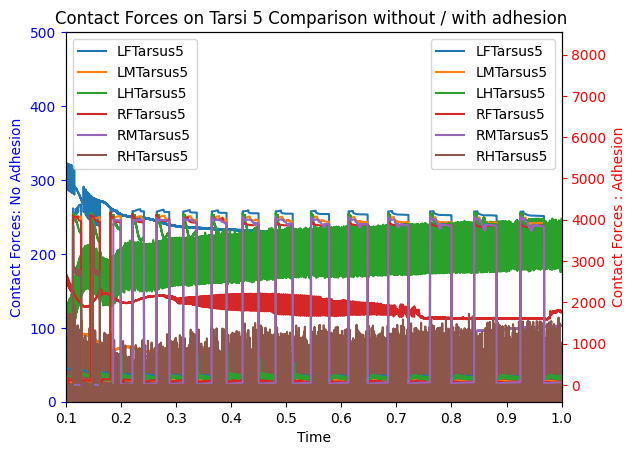

In [107]:
# tarsi
tarsi = np.array(['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5'])

# Extract the time and fly data for each simulation
print(len( contact_forces_simulation1))
time_simulation =np.arange(len(contact_forces_simulation1))*nmf.timestep

# Create the figure and primary axis
fig, ax1 = plt.subplots()

# Plot data from the first simulation on the primary axis
ax1.plot(time_simulation, contact_forces_simulation1, label=tarsi)
ax1.set_xlabel('Time')
ax1.set_ylabel('Contact Forces: No Adhesion', color='b')
ax1.tick_params('y', colors='b')
#ax1.legend(tarsi, loc='upper left')
ax1.legend(loc = 'upper left')
ax1.set_xlim(time_simulation[-1]*0.1,time_simulation[-1])
ax1.set_ylim(0, 500)

# Create the secondary axis
ax2 = ax1.twinx()

# Plot data from the second simulation on the secondary axis
ax2.plot(time_simulation, contact_forces_simulation2, label= tarsi)
ax2.set_ylabel('Contact Forces : Adhesion', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc = 'upper right')
ax2.set_xlim(time_simulation[-1]*0.1,time_simulation[-1])


# Title and show the plot
plt.title('Contact Forces on Tarsi 5 Comparison without / with adhesion ')
plt.show()


## after medfilt

10001


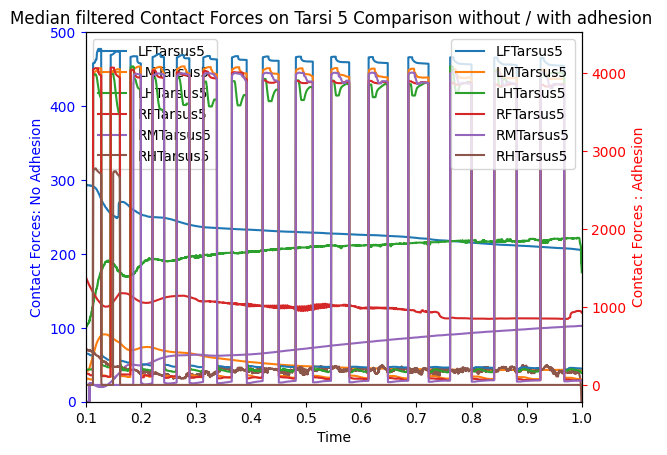

In [114]:
#define window size for medfilt
window_size = 101
# tarsi
tarsi = np.array(['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5'])

# Extract the time and fly data for each simulation
print(len( contact_forces_simulation1))
time_simulation =np.arange(len(contact_forces_simulation1))*nmf.timestep

# Create the figure and primary axis
fig, ax1 = plt.subplots()

# Plot data from the first simulation on the primary axis
ax1.plot(time_simulation, medfilt(contact_forces_simulation1, (window_size,1)), label=tarsi)
ax1.set_xlabel('Time')
ax1.set_ylabel('Contact Forces: No Adhesion', color='b')
ax1.tick_params('y', colors='b')
#ax1.legend(tarsi, loc='upper left')
ax1.legend(loc = 'upper left')
ax1.set_xlim(time_simulation[-1]*0.1,time_simulation[-1])
ax1.set_ylim(0, 500)

# Create the secondary axis
ax2 = ax1.twinx()

# Plot data from the second simulation on the secondary axis
ax2.plot(time_simulation, medfilt(contact_forces_simulation2, kernel_size=(window_size, 1)), label= tarsi)
ax2.set_ylabel('Contact Forces : Adhesion', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc = 'upper right')
ax2.set_xlim(time_simulation[-1]*0.1,time_simulation[-1])


# Title and show the plot
plt.title('Median filtered Contact Forces on Tarsi 5 Comparison without / with adhesion ')
plt.show()


## part 2: Dynamic analysis split by leg 

-plot all contact forces (independent of tarsi, for each leg); this is to see whether the contribution of the other tarsi are relevant. Plot also the sum of all contact forces onto the same graph. 

In [3]:
# Initialize simulation
run_time = 1
nmf = NeuroMechFlyMuJoCo(render_mode='headless', #no graphic rendering: headless, rendering = 'saved'
                         timestep=1e-4,
                         #render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs,
                         adhesion = False,
                         actuators_adhesion_gain = 1942.73,#at 20500 it flies away, at 21000 it stays
                         actuated_bodies='all')

# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
#with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
#    data = pickle.load(f)
with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
    data = pickle.load(f)

# Interpolate 5x recording 
num_steps = int(run_time / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), num_steps))
measure_t = np.arange(len(data['joint_LFCoxa'])) * data['meta']['timestep']
interp_t = np.arange(num_steps) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1942.73"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1942.73"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1942.73"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1942.73"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1942.73"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1942.73"/>] actuators _adhesion


In [4]:
# Run simulation
nmf.physics.model.opt.gravity = (0,0,-9.81e5)
obs, info = nmf.reset() 
old_obs = obs
obs_list = [obs]
obs_deriv_touch_sensor_Tarsi5 = []
adhesion_obs = []
for i in trange(num_steps):
    deriv_touch_sensor_Tarsi5 = (obs['contact_forces'][4::5]- old_obs['contact_forces'][4::5])/nmf.timestep
    obs_deriv_touch_sensor_Tarsi5.append(deriv_touch_sensor_Tarsi5)
    """
    if i >= int(num_steps/2):
        #inverting gravity midsimulation
        nmf.physics.model.opt.gravity = (0,0,9.81e5)
    """
    joint_pos = data_block[:, i] #put back i 
    #calculate adhesion
    action = {'joints': joint_pos, 'adhesion': np.zeros(6)} #old version: action = {'joints': joint_pos, 'adhesion': obs['bodies_adhesion']}
    old_obs = obs
    obs, info = nmf.step(action)
    
    nmf.render()
    obs_list.append(obs)

100%|██████████| 10000/10000 [00:41<00:00, 243.81it/s]


In [15]:
for obs in obs_list: 
    print(obs['contact_forces'][4::5])

[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]


In [5]:
# Create a list to hold the end effector data len(end_effector_data = 18;)
end_effector_data = [[] for _ in range(18)]

# Iterate through each observation in obs_list
for obs in obs_list:
    end_effectors = obs['end_effectors']
    # Iterate through each value in the end_effectors list and append to the corresponding sublist in end_effector_data
    for i, value in enumerate(end_effectors):
        end_effector_data[i].append(value)

end_effector_data = {'x_vals_end_effector_obs' : end_effector_data[::3], 'y_vals_end_effector_obs': end_effector_data[1::3] , 'z_vals_end_effector_obs': end_effector_data[2::3]}

[ 2073.38949628   140.68030985  1487.44469631 -2127.00269976
  1184.48397557  1503.21426628    30.61927828  2193.01683175
  1297.61515485  2071.5947581   -204.99138534  1494.01496955
 -2119.0006488  -1234.3258386   1503.64598778    47.42740823
 -2247.09840987  1290.64535695]
[ 2072.37468877   142.5245455   1490.18065224 -2126.61439642
  1184.80608391  1506.16496015    30.86587272  2192.62660984
  1300.47212187  2071.24626812  -206.15643087  1496.83744636
 -2118.78026877 -1234.65987249  1506.2565093     47.77556013
 -2247.12170067  1293.5642266 ]
[ 2070.14643437   146.21404873  1493.85414475 -2124.89284701
  1184.77571643  1510.70446006    31.02860716  2191.25587335
  1304.70011111  2070.24203797  -208.27418838  1500.69393282
 -2117.64419945 -1235.29140531  1510.27276767    48.20803441
 -2246.38792869  1298.13498919]
[ 2066.77040944   151.61642004  1497.31974706 -2121.66721566
  1184.12247579  1515.41118546    30.9527012   2188.70773653
  1308.93630974  2068.46963921  -211.23077433  150

In [9]:
np.shape(end_effector_data['x_vals_end_effector_obs'])

(6, 10001)

In [10]:
nmf.reset()

legs = ["RH", "LH", "RF", "LF", "RM", "LM"]
leg_ids = np.arange(len(legs)).astype(int)
leg_corresp_id = dict(zip(legs, leg_ids))

In [11]:
leg_corresp_id

{'RH': 0, 'LH': 1, 'RF': 2, 'LF': 3, 'RM': 4, 'LM': 5}

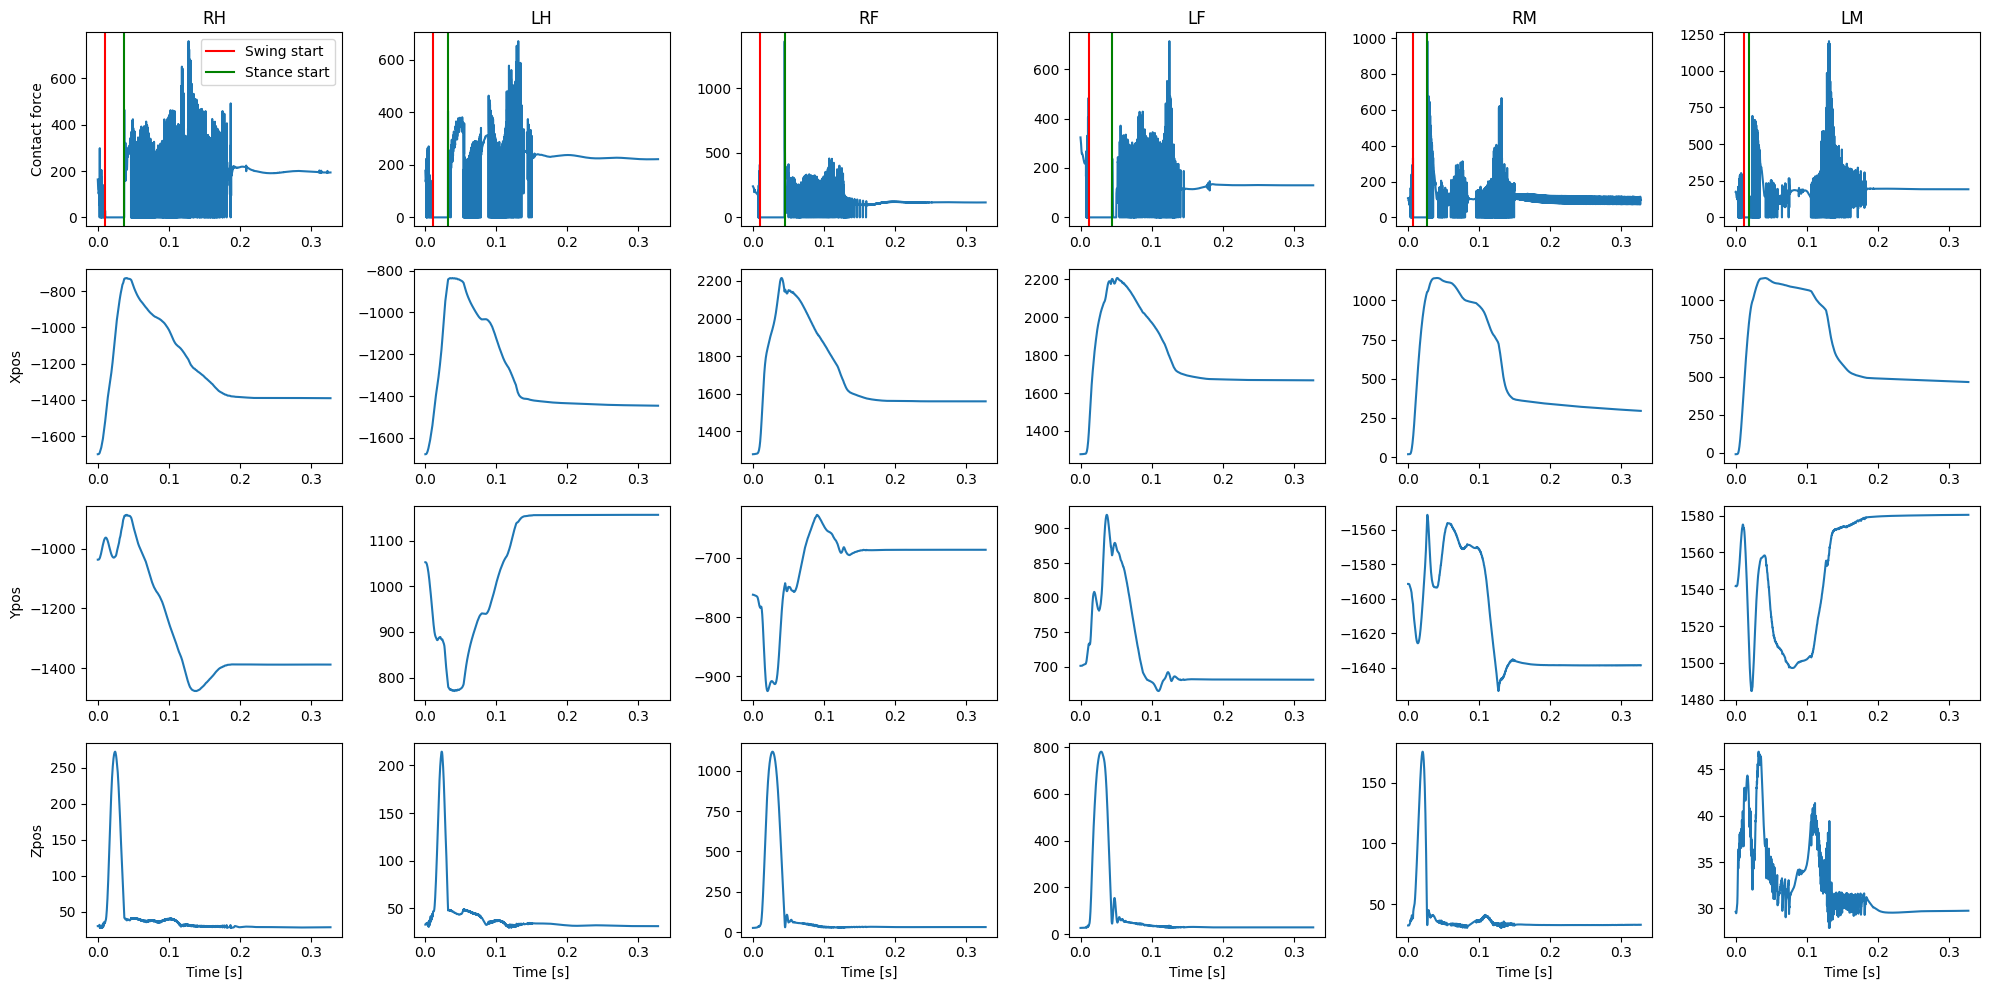

In [ ]:
fig, axs = plt.subplots(5, len(legs), figsize=(20, 10))
t = np.arange(touch_sensor_data.shape[1])*nmf.timestep

for i, leg in enumerate(legs):
    # Plot contact forces
    axs[0, i].plot(t, touch_sensor_data[i, :])
    k = 0

    # Plot 3d coordinates of the last segment of the tarsus
    axs[1, i].plot(t, position_data[i, :, 0])
    axs[2, i].plot(t, position_data[i, :, 1])
    axs[3, i].plot(t, position_data[i, :, 2])
    axs[0, i].set_title(leg)
    if i == 0:
        axs[0, i].set_ylabel('Contact force')
        axs[1, i].set_ylabel('Xpos')
        axs[2, i].set_ylabel('Ypos')
        axs[3, i].set_ylabel('Zpos')
for j in range(len(legs)):
    axs[-1, j].set_xlabel('Time [s]')    

plt.tight_layout()

### auxiliary functions